In [1]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report , ConfusionMatrixDisplay

#Deep learnings tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Flatten , Activation , Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from keras.applications import Xception,VGG16,ResNet50
#warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

# Path to the ZIP file
zip_file_path = '/content/drive/MyDrive/scence classification zipped/archive.zip'

# Directory where you want to extract the contents
extract_dir = 'extracted_files'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

##Data Preparation

In [4]:
train_data = '/content/extracted_files/seg_train/seg_train'
test_data = '/content/extracted_files/seg_test/seg_test'

filepath= []
label =[]

folds = os.listdir(train_data)

for fold in folds:
    f_path = os.path.join(train_data , fold)
    imgs = os.listdir(f_path)

    for img in imgs:
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)

#Concat data paths with labels
fseries = pd.Series(filepath , name= 'filepaths')
lseries = pd.Series(label , name = 'labels')
train_df = pd.concat([fseries , lseries] , axis = 1)

In [5]:
folds = os.listdir(test_data)

for fold in folds:
    f_path = os.path.join(test_data , fold)
    imgs = os.listdir(f_path)

    for img in imgs:
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)

#Concat data paths with labels
fseries = pd.Series(filepath , name= 'filepaths')
lseries = pd.Series(label , name = 'labels')
ts_df = pd.concat([fseries , lseries] , axis = 1)

In [6]:
train_df

,filepaths,labels
0,/content/extracted_files/seg_train/seg_train/s...,street
1,/content/extracted_files/seg_train/seg_train/s...,street
2,/content/extracted_files/seg_train/seg_train/s...,street
3,/content/extracted_files/seg_train/seg_train/s...,street
4,/content/extracted_files/seg_train/seg_train/s...,street
...,...,...
14029,/content/extracted_files/seg_train/seg_train/s...,sea
14030,/content/extracted_files/seg_train/seg_train/s...,sea
14031,/content/extracted_files/seg_train/seg_train/s...,sea
14032,/content/extracted_files/seg_train/seg_train/s...,sea


In [7]:
ts_df

,filepaths,labels
0,/content/extracted_files/seg_train/seg_train/s...,street
1,/content/extracted_files/seg_train/seg_train/s...,street
2,/content/extracted_files/seg_train/seg_train/s...,street
3,/content/extracted_files/seg_train/seg_train/s...,street
4,/content/extracted_files/seg_train/seg_train/s...,street
...,...,...
17029,/content/extracted_files/seg_test/seg_test/sea...,sea
17030,/content/extracted_files/seg_test/seg_test/sea...,sea
17031,/content/extracted_files/seg_test/seg_test/sea...,sea
17032,/content/extracted_files/seg_test/seg_test/sea...,sea


##Data Splitting

In [8]:
valid , test = train_test_split(ts_df , test_size= 0.5 , shuffle = True , random_state = 42)

In [ ]:
print(f"Shape of Validation set is: {valid.shape}")
print(f"Shape of Test set is: {test.shape}")

In [9]:
#img_size = (150 ,150)
#batch_size = 32

#tr_gen = ImageDataGenerator()
#ts_gen= ImageDataGenerator()

#original_train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      #class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size= batch_size)

#valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                       #class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

#test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      #class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

In [10]:
def random_label_flipping(dataframe, class_labels, flip_percentage=0.05):
    # Determine the number of samples to flip
    num_samples = len(dataframe)
    num_to_flip = int(num_samples * flip_percentage)

    # Randomly choose indices to flip
    flip_indices = np.random.choice(num_samples, size=num_to_flip, replace=False)

    # Dictionary to store the mapping of flipped indices to new class names
    flipped_mapping = {}

    # Flip the labels
    for idx in flip_indices:
        current_label = dataframe.iloc[idx]['labels']
        current_label_index = class_labels.index(current_label)
        # Choose a new label different from the current one
        new_label_index = np.random.choice([i for i in range(len(class_labels)) if i != current_label_index])
        new_label = class_labels[new_label_index]
        dataframe.at[idx, 'labels'] = new_label
        # Store the mapping of the flipped index to the new class name
        flipped_mapping[idx] = new_label

    return dataframe, flipped_mapping

# Example class labels
class_labels = list( train_df['labels'].unique())

# Load your dataframes (example)
# train_df = pd.read_csv('path/to/train.csv')
# valid = pd.read_csv('path/to/valid.csv')
# test = pd.read_csv('path/to/test.csv')

# Apply label flipping to the train_df and get the mapping of flipped indices
train_df, flipped_mapping = random_label_flipping(ts_df, class_labels, flip_percentage=0.05)

# Convert labels to strings
train_df['labels'] = train_df['labels'].astype(str)
valid['labels'] = valid['labels'].astype(str)
test['labels'] = test['labels'].astype(str)

# Print the mapping of flipped indices to new class names
print("Mapping of flipped indices to new class names:")
for index, new_class in flipped_mapping.items():
    print(f"Index: {index}, New Class: {new_class}")

# Define image size and batch size
img_size = (150, 150)
batch_size = 32

# Create ImageDataGenerators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# Create data generators
train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Mapping of flipped indices to new class names:
Index: 16282, New Class: street
Index: 1360, New Class: glacier
Index: 9334, New Class: buildings
Index: 1828, New Class: mountain
Index: 10660, New Class: mountain
Index: 10733, New Class: forest
Index: 14217, New Class: buildings
Index: 13127, New Class: glacier
Index: 16046, New Class: buildings
Index: 7199, New Class: buildings
Index: 3574, New Class: street
Index: 8691, New Class: forest
Index: 3004, New Class: glacier
Index: 2521, New Class: mountain
Index: 7878, New Class: street
Index: 801, New Class: buildings
Index: 6502, New Class: forest
Index: 107, New Class: buildings
Index: 10705, New Class: glacier
Index: 13323, New Class: mountain
Index: 7869, New Class: street
Index: 1066, New Class: mountain
Index: 1093, New Class: buildings
Index: 2076, New Class: mountain
Index: 9193, New Class: forest
Index: 13301, New Class: street
Index: 666, New Class: glacier
Index: 6306, New Class: street
Index: 131, New Class: glacier
Index: 167

##Image generator

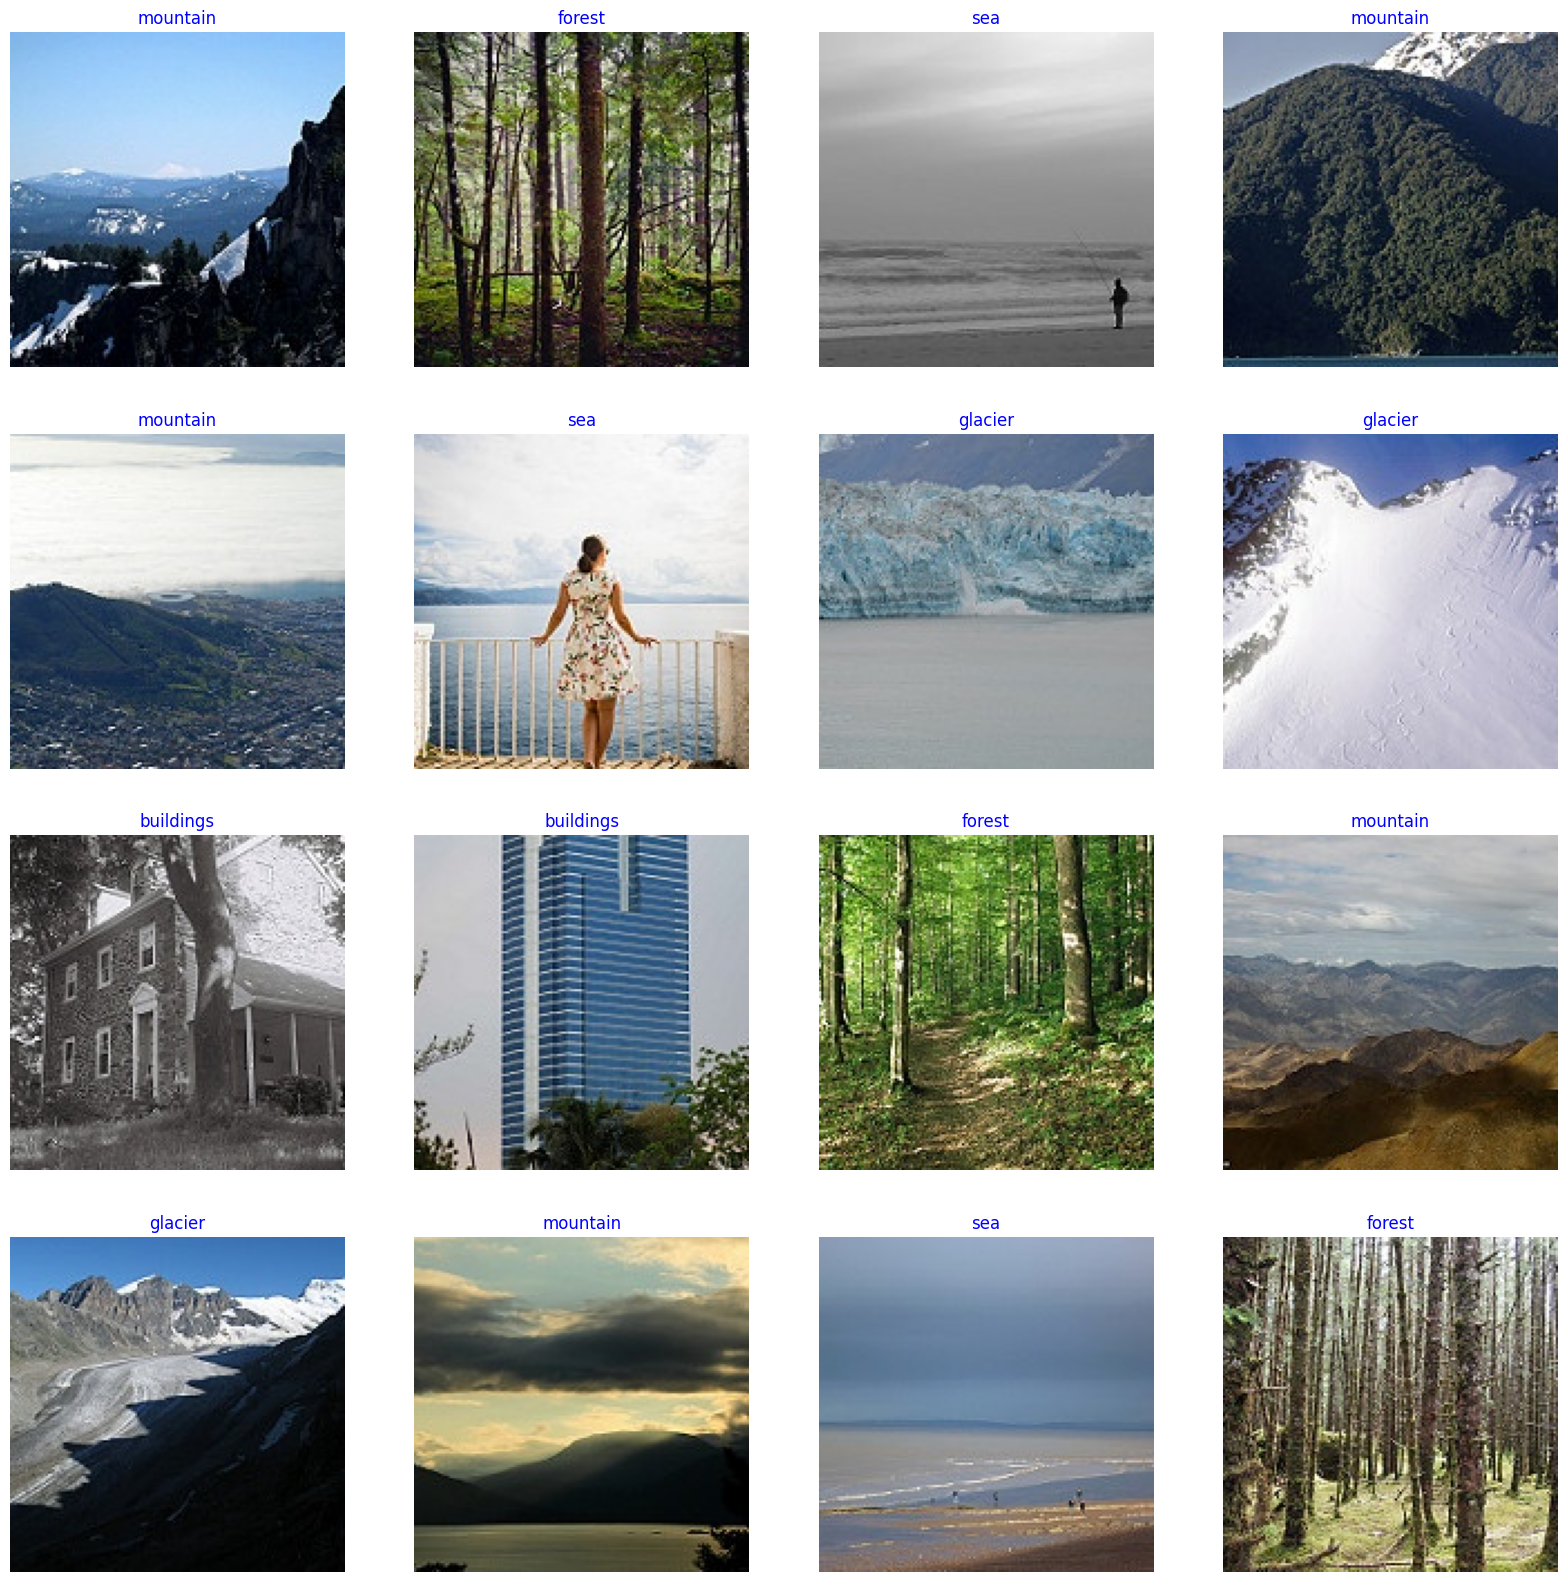

In [11]:
dict_gen = train_gen.class_indices
classes = list(dict_gen.keys())
images , labels = next(train_gen)

plt.figure(figsize=(20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

##Model Structure

In [12]:
img_shape = (img_size[0] , img_size[1] , 3)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False , weights= 'imagenet' , input_shape= img_shape , pooling= 'max')

num_classes = len(classes)

model = Sequential([
    base_model,
    BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
    Dense(256 , activation= 'relu'),
    Dense(256 , activation= 'relu'),
    Dense(num_classes , activation= 'softmax')
])
model.compile(Adamax(learning_rate= 0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 6)                 1542      
                                                         

##Model Performance

In [13]:
epochs = 10

history = model.fit(train_gen , epochs =epochs , verbose = 1 ,validation_data= valid_gen,validation_steps=None , shuffle = False )

Epoch 1/10
533/533 [==============================] - 136s 183ms/step - loss: 0.6041 - accuracy: 0.8297 - val_loss: 0.1971 - val_accuracy: 0.9481
Epoch 2/10
533/533 [==============================] - 84s 157ms/step - loss: 0.4186 - accuracy: 0.8876 - val_loss: 0.1312 - val_accuracy: 0.9679
Epoch 3/10
533/533 [==============================] - 84s 158ms/step - loss: 0.3140 - accuracy: 0.9110 - val_loss: 0.1579 - val_accuracy: 0.9634
Epoch 4/10
533/533 [==============================] - 84s 157ms/step - loss: 0.2156 - accuracy: 0.9335 - val_loss: 0.1869 - val_accuracy: 0.9563
Epoch 5/10
533/533 [==============================] - 84s 158ms/step - loss: 0.1537 - accuracy: 0.9499 - val_loss: 0.2382 - val_accuracy: 0.9505
Epoch 6/10
533/533 [==============================] - 82s 155ms/step - loss: 0.1120 - accuracy: 0.9624 - val_loss: 0.2869 - val_accuracy: 0.9515
Epoch 7/10
533/533 [==============================] - 85s 159ms/step - loss: 0.0831 - accuracy: 0.9734 - val_loss: 0.3511 - val_a

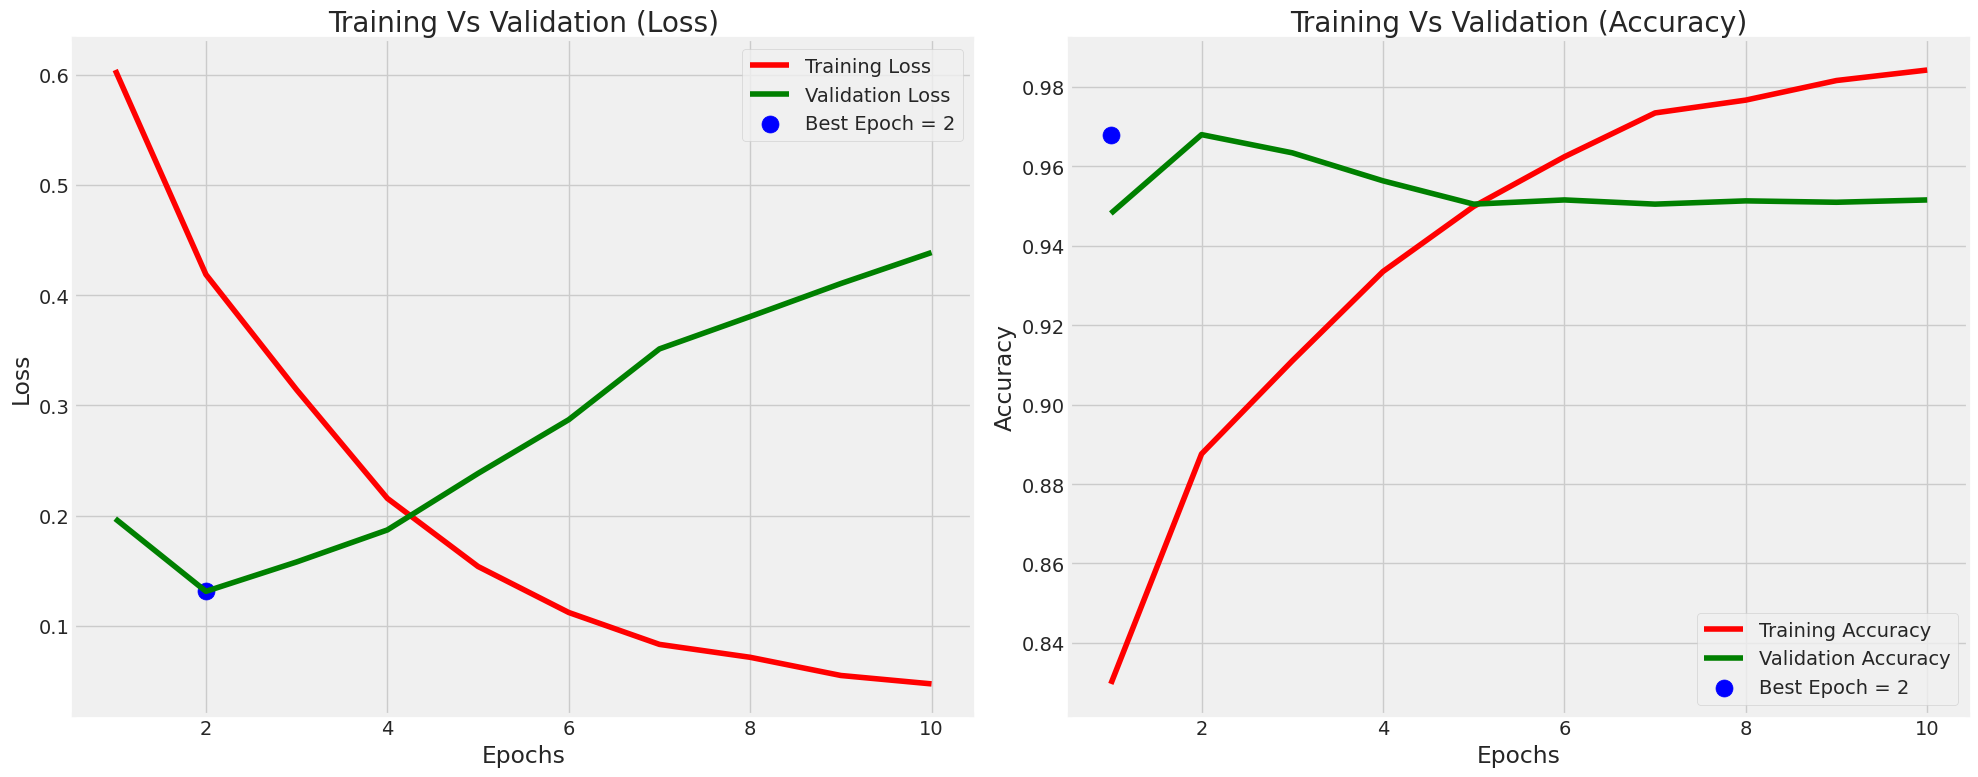

In [14]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_loss = f'Best Epoch = {str(index_acc +1)}'

#Training Accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label= loss_label)
plt.title('Training Vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();

##Model Evaluation

In [15]:
train_score = model.evaluate(train_gen , steps = 32 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 32 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 32 , verbose = 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

32/32 [==============================] - 2s 53ms/step - loss: 0.6388 - accuracy: 0.9287
Train Loss:  0.01945222169160843
Train Accuracy:  0.9970703125
--------------------
Validation Loss:  0.4129127562046051
Validation Accuracy:  0.953125
--------------------
Test Loss:  0.6388285756111145
Test Accuracy:  0.9287109375


##Model Prediction

##Confusion Matrix

In [16]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)

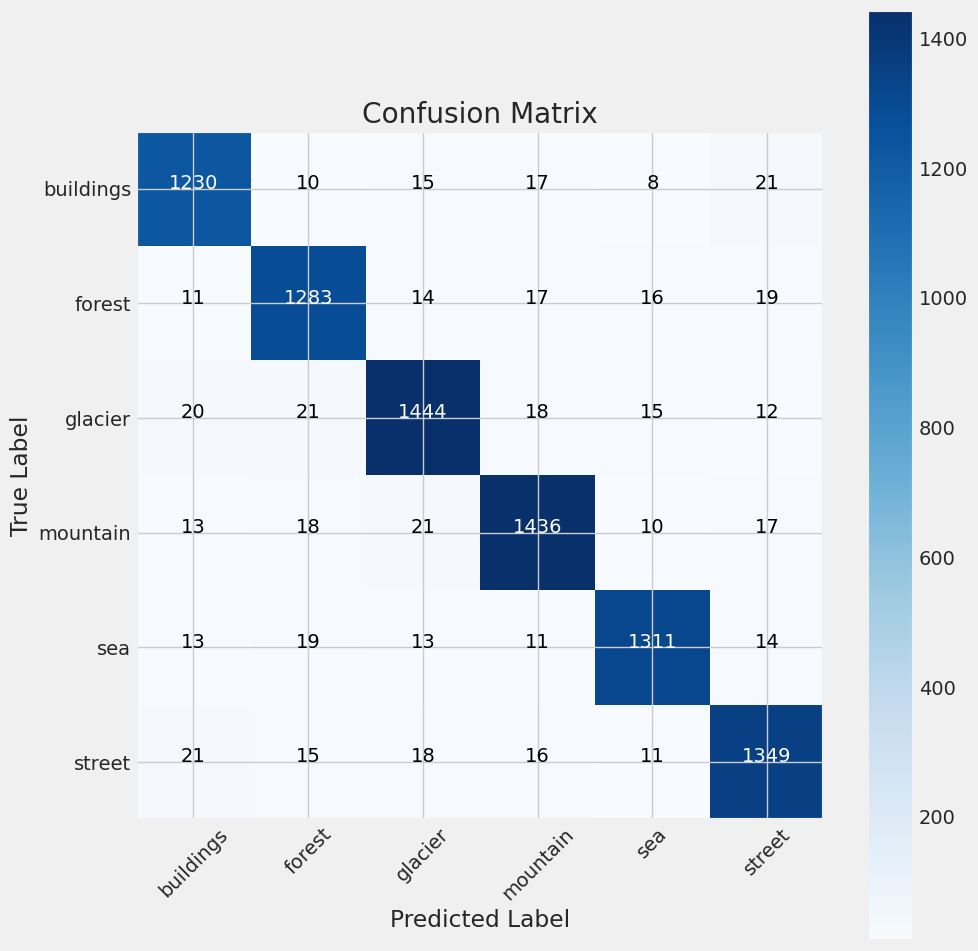

In [17]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

##Classification Report

In [18]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

   buildings       0.94      0.95      0.94      1301
      forest       0.94      0.94      0.94      1360
     glacier       0.95      0.94      0.95      1530
    mountain       0.95      0.95      0.95      1515
         sea       0.96      0.95      0.95      1381
      street       0.94      0.94      0.94      1430

    accuracy                           0.95      8517
   macro avg       0.95      0.95      0.95      8517
weighted avg       0.95      0.95      0.95      8517



In [19]:
base_model = ResNet50(include_top= False , weights= 'imagenet' , input_shape= img_shape , pooling= 'max')

num_classes = len(classes)

model2 = Sequential([
    base_model,
    BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
    Dense(256 , activation= 'relu'),
    Dense(256 , activation= 'relu'),
    Dense(num_classes , activation= 'softmax')
])
model2.compile(Adamax(learning_rate= 0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model2.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 24187782 (92.27 MB)
Trainable params: 241

In [20]:
epochs = 10

history2 = model.fit(train_gen , epochs =epochs , verbose = 1 ,validation_data= valid_gen,validation_steps=None , shuffle = False )

Epoch 1/10
533/533 [==============================] - 85s 160ms/step - loss: 0.0499 - accuracy: 0.9839 - val_loss: 0.4483 - val_accuracy: 0.9505
Epoch 2/10
533/533 [==============================] - 84s 157ms/step - loss: 0.0398 - accuracy: 0.9864 - val_loss: 0.4698 - val_accuracy: 0.9517
Epoch 3/10
533/533 [==============================] - 85s 159ms/step - loss: 0.0440 - accuracy: 0.9850 - val_loss: 0.4724 - val_accuracy: 0.9509
Epoch 4/10
533/533 [==============================] - 84s 157ms/step - loss: 0.0357 - accuracy: 0.9869 - val_loss: 0.4894 - val_accuracy: 0.9515
Epoch 5/10
533/533 [==============================] - 83s 156ms/step - loss: 0.0356 - accuracy: 0.9886 - val_loss: 0.4772 - val_accuracy: 0.9519
Epoch 6/10
533/533 [==============================] - 85s 159ms/step - loss: 0.0381 - accuracy: 0.9867 - val_loss: 0.5109 - val_accuracy: 0.9516
Epoch 7/10
533/533 [==============================] - 86s 161ms/step - loss: 0.0334 - accuracy: 0.9891 - val_loss: 0.5409 - val_ac

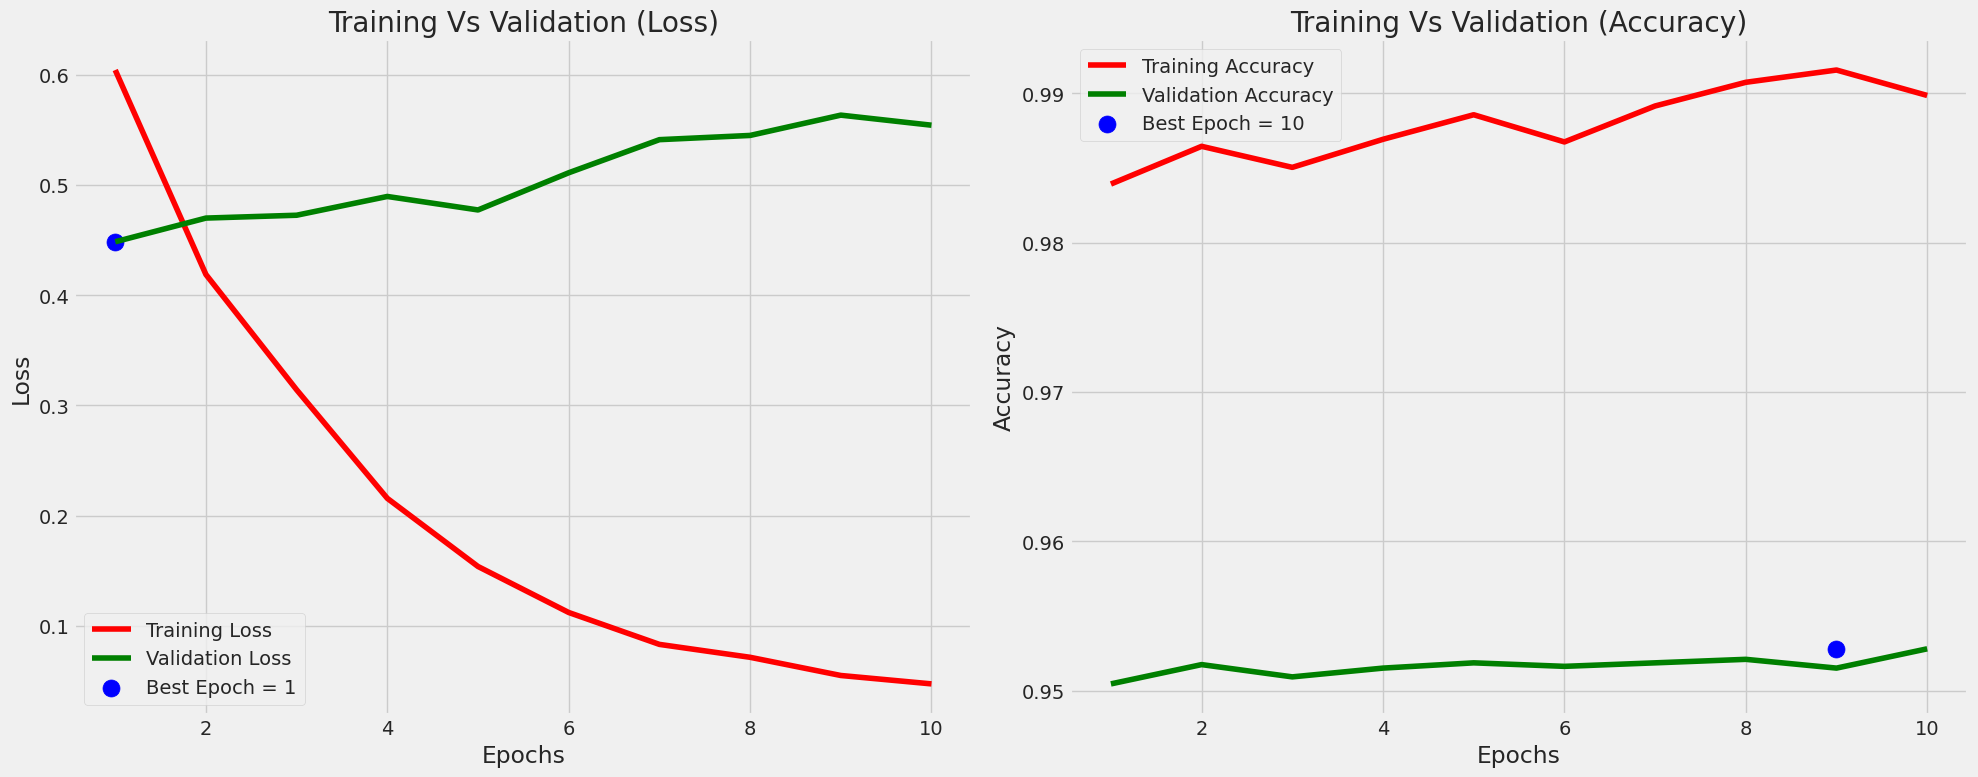

In [21]:
train_acc = history2.history['accuracy']
train_loss = history.history['loss']

val_acc = history2.history['val_accuracy']
val_loss = history2.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_loss = f'Best Epoch = {str(index_acc +1)}'

#Training Accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label= loss_label)
plt.title('Training Vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();

## Model(s) for the flipped images

In [22]:
img_shape = (img_size[0] , img_size[1] , 3)
base_model1 = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False , weights= 'imagenet' , input_shape= img_shape , pooling= 'max')

num_classes = len(classes)

model1 = Sequential([
    base_model1,
    BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
    Dense(256 , activation= 'relu'),
    Dense(256 , activation= 'relu'),
    Dense(num_classes , activation= 'softmax')
])
model1.compile(Adamax(learning_rate= 0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [24]:
epochs = 10

history1 = model1.fit(x = train_gen , epochs =epochs , verbose = 1 ,validation_data= valid_gen,validation_steps=None , shuffle = False)

Epoch 1/10
533/533 [==============================] - 119s 159ms/step - loss: 0.5955 - accuracy: 0.8359 - val_loss: 0.1988 - val_accuracy: 0.9433
Epoch 2/10
533/533 [==============================] - 84s 157ms/step - loss: 0.4141 - accuracy: 0.8890 - val_loss: 0.1344 - val_accuracy: 0.9652
Epoch 3/10
533/533 [==============================] - 84s 158ms/step - loss: 0.3104 - accuracy: 0.9114 - val_loss: 0.1297 - val_accuracy: 0.9635
Epoch 4/10
533/533 [==============================] - 83s 156ms/step - loss: 0.2161 - accuracy: 0.9340 - val_loss: 0.1798 - val_accuracy: 0.9567
Epoch 5/10
533/533 [==============================] - 86s 162ms/step - loss: 0.1556 - accuracy: 0.9498 - val_loss: 0.2644 - val_accuracy: 0.9529
Epoch 6/10
533/533 [==============================] - 83s 156ms/step - loss: 0.1118 - accuracy: 0.9634 - val_loss: 0.2969 - val_accuracy: 0.9514
Epoch 7/10
533/533 [==============================] - 84s 158ms/step - loss: 0.0871 - accuracy: 0.9719 - val_loss: 0.3379 - val_a

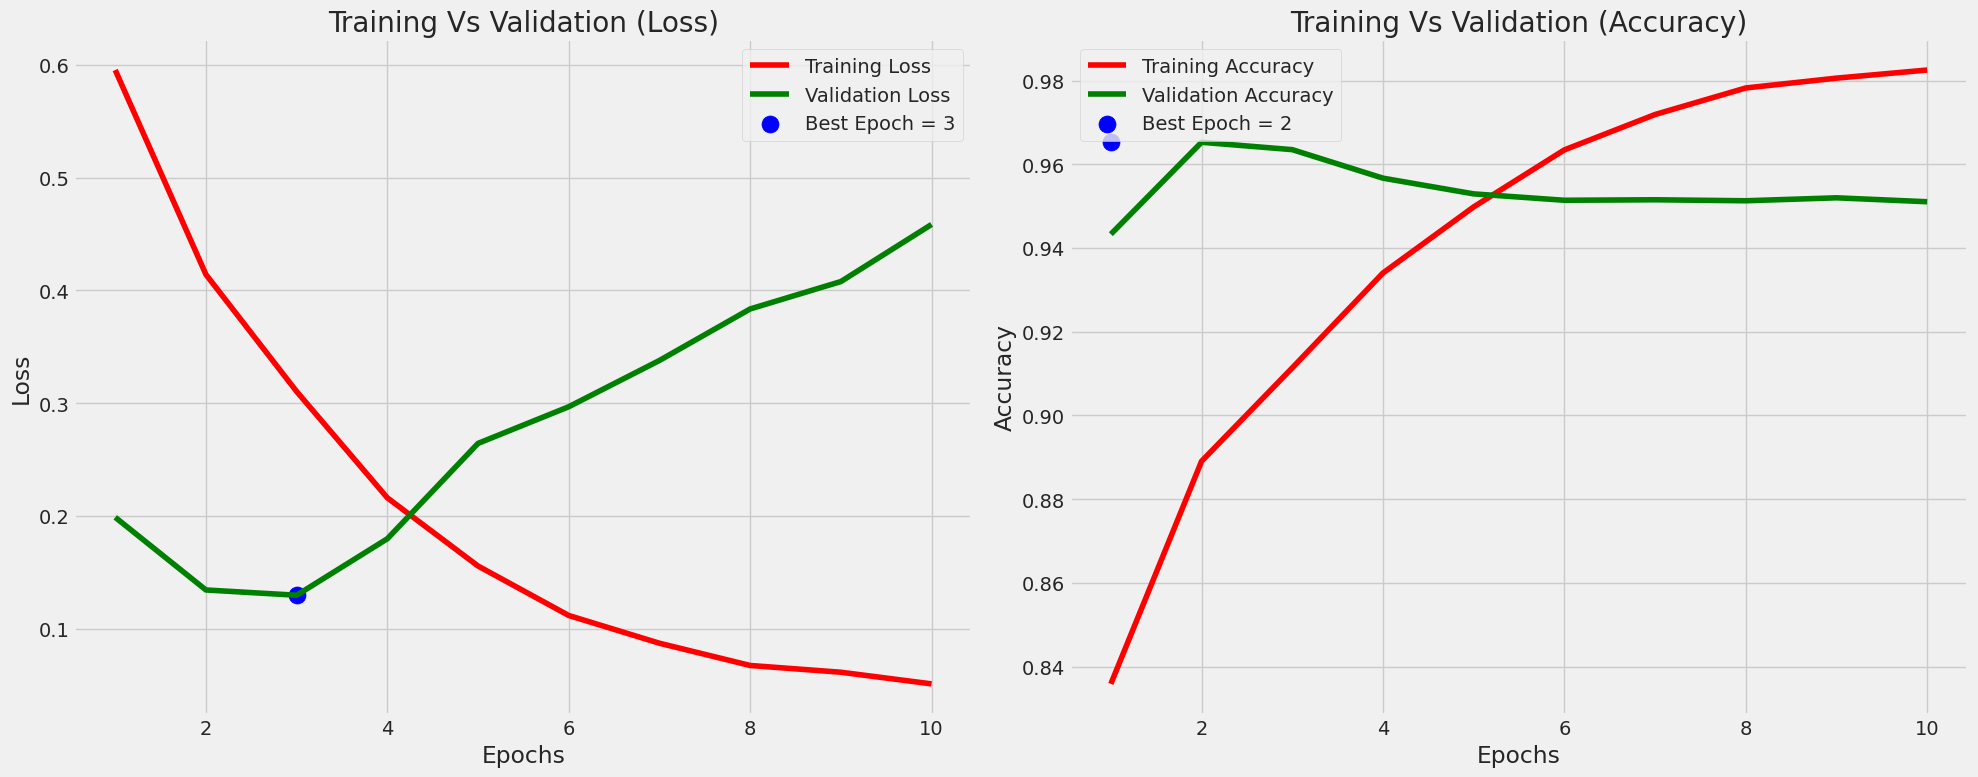

In [25]:
train_acc = history1.history['accuracy']
train_loss = history1.history['loss']

val_acc = history1.history['val_accuracy']
val_loss = history1.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_loss = f'Best Epoch = {str(index_acc +1)}'

#Training Accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label= loss_label)
plt.title('Training Vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();